# GX 6004-001:  Applied Data Science (Session 3)

# Cleaning Data: A (Large) Component of Data Science

* The reason I discourage the use of currated datasets for the ADS project is that a large component of ADS is data cleaning and curation.
* Necessary (and mildly unpleasant).
* **Know your data.**
* I want to show you some Python code to assist in data cleaning.
* Pull some data from the web.
* We will then turn to two curated datasets for regression with multiple features.

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from tabulate import tabulate
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)

Populating the interactive namespace from numpy and matplotlib


#### Notes

* These data are available on the NYC Open Data Portal: House sales in Staten Island betweeen 2003 and 2007.
* We are going to input using Panda's ability to read Excel files.
* We are going to 'stack' the data because each file has the same format.
* We will then clean the data for use.
* We will spend some time walking through the code, so you can re-use.  

In [2]:
sales03 = pd.read_excel("sales_si_03.xls", header=3, index_col=None)
sales03.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,5,ANNADALE,01 ONE FAMILY HOMES,1,5391,7,,A5,4732 AMBOY ROAD,,...,1,0,1,3655,1110,2002,1,A5,365040,2003-03-05
1,5,ANNADALE,01 ONE FAMILY HOMES,1,5391,8,,A5,4730 AMBOY ROAD,,...,1,0,1,3149,1110,2002,1,A5,353886,2003-01-13
2,5,ANNADALE,01 ONE FAMILY HOMES,1,5391,12,,A5,4718 AMBOY ROAD,,...,1,0,1,1746,1110,2002,1,A5,310000,2003-07-25
3,5,ANNADALE,01 ONE FAMILY HOMES,1,5391,13,,A5,4716 AMBOY ROAD,,...,1,0,1,1871,1110,2002,1,A5,299130,2003-09-05
4,5,ANNADALE,01 ONE FAMILY HOMES,1,5391,15,,A5,4714 AMBOY ROAD,,...,1,0,1,4678,1110,2002,1,A5,304099,2003-09-19


In [3]:
sales03 = pd.read_excel("sales_si_03.xls", header=3, index_col=None)
sales04 = pd.read_excel("sales_si_04.xls", header=3, index_col=None)
sales05 = pd.read_excel("sales_si_05.xls", header=3, index_col=None)
sales06 = pd.read_excel("sales_si_06.xls", header=3, index_col=None)
sales = pd.concat([sales03, sales04, sales05, sales06])

In [4]:
sales.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,5,ANNADALE,01 ONE FAMILY HOMES,1,5391,7,,A5,4732 AMBOY ROAD,,...,1,0,1,3655,1110,2002,1,A5,365040,2003-03-05
1,5,ANNADALE,01 ONE FAMILY HOMES,1,5391,8,,A5,4730 AMBOY ROAD,,...,1,0,1,3149,1110,2002,1,A5,353886,2003-01-13
2,5,ANNADALE,01 ONE FAMILY HOMES,1,5391,12,,A5,4718 AMBOY ROAD,,...,1,0,1,1746,1110,2002,1,A5,310000,2003-07-25
3,5,ANNADALE,01 ONE FAMILY HOMES,1,5391,13,,A5,4716 AMBOY ROAD,,...,1,0,1,1871,1110,2002,1,A5,299130,2003-09-05
4,5,ANNADALE,01 ONE FAMILY HOMES,1,5391,15,,A5,4714 AMBOY ROAD,,...,1,0,1,4678,1110,2002,1,A5,304099,2003-09-19


#### Notes

* Let's examine summary statistics of the numeric features: **Know your data**.
* Borough has mean 5.0 and standard deviation 0.  Does this make sense?
* Block and Lot have a minimum value of 1, which is odd, as is Zip Code of 0.
* Some houses have 0 residential units, which is also odd.
* 0 square footage (or 0 square meters) is also odd.
* Lots of zero price sales.

In [5]:
sales.describe()

,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE
count,46381.0,46381.000000,46381.000000,46381.000000,46381.000000,46381.000000,46381.000000,4.638100e+04,46381.000000,46381.000000,46381.000000,4.638100e+04
mean,5.0,3221.105496,186.420150,10280.586943,1.327462,0.315172,1.642634,6.192493e+03,2109.868718,1875.196675,1.158556,2.903822e+05
std,0.0,2360.069542,440.855935,527.980830,4.970062,26.020568,26.476876,8.657732e+04,9196.425843,421.952633,0.607804,1.116870e+06
min,5.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000e+00
25%,5.0,1057.000000,24.000000,10304.000000,1.000000,0.000000,1.000000,1.920000e+03,1120.000000,1940.000000,1.000000,0.000000e+00
50%,5.0,2983.000000,53.000000,10307.000000,1.000000,0.000000,1.000000,3.000000e+03,1657.000000,1975.000000,1.000000,2.700000e+05
75%,5.0,5327.000000,124.000000,10312.000000,2.000000,0.000000,2.000000,4.500000e+03,2220.000000,1995.000000,1.000000,4.100000e+05
max,5.0,8050.000000,7502.000000,10314.000000,403.000000,4964.000000,4964.000000,1.080288e+07,881000.000000,2012.000000,4.000000,1.894423e+08


#### Notes

* Note the syntax of these commands:
    * $==$ limits the datafram to those observations that resolve as **True**.
    * $<=$ does the same thing.
    * $>$ does the same thing.
* Deconstruct logical statements and the syntax.
* Are these restrictions resonable?

In [6]:
sales = sales[sales['RESIDENTIAL UNITS'] == 1]

sales = sales[sales['COMMERCIAL UNITS'] == 0]

sales = sales[sales['YEAR BUILT'] <= 2006]

sales = sales[sales['LAND SQUARE FEET'] > 0]
sales = sales[sales['GROSS SQUARE FEET'] > 0]
sales = sales[sales['LAND SQUARE FEET'] <= 6000]
sales = sales[sales['GROSS SQUARE FEET'] <= 4000]

sales = sales[sales['TAX CLASS AT TIME OF SALE'] == 1]

sales = sales[sales['SALE PRICE'] >= 1000]
sales = sales[sales['SALE PRICE'] <= 6000000]

In [7]:
sales.describe()

,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE
count,16633.0,16633.000000,16633.000000,16633.000000,16633.0,16633.0,16633.0,16633.000000,16633.000000,16633.000000,16633.0,1.663300e+04
mean,5.0,3439.546324,85.835147,10307.941021,1.0,0.0,1.0,2730.830698,1600.299044,1973.760777,1.0,3.541230e+05
std,0.0,2255.979695,98.761740,4.029228,0.0,0.0,0.0,1313.081728,545.022600,30.117280,0.0,1.549677e+05
min,5.0,13.000000,1.000000,10301.000000,1.0,0.0,1.0,262.000000,260.000000,1890.000000,1.0,1.000000e+03
25%,5.0,1228.000000,24.000000,10305.000000,1.0,0.0,1.0,1800.000000,1218.000000,1955.000000,1.0,2.700000e+05
50%,5.0,3319.000000,52.000000,10307.000000,1.0,0.0,1.0,2500.000000,1524.000000,1986.000000,1.0,3.484860e+05
75%,5.0,5458.000000,109.000000,10312.000000,1.0,0.0,1.0,3795.000000,1900.000000,1999.000000,1.0,4.240000e+05
max,5.0,8050.000000,930.000000,10314.000000,1.0,0.0,1.0,6000.000000,4000.000000,2006.000000,1.0,5.075000e+06


#### Notes
* Often we only need a subset of the data and want to rename columns.
* First line of code restricts the dataframe.
* Second renames the features we wish to use.

In [8]:
sales = sales[['NEIGHBORHOOD', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'SALE PRICE', 'SALE DATE']]
sales = sales.rename(columns={"NEIGHBORHOOD": "nb", "LAND SQUARE FEET": "lsf",
                    "GROSS SQUARE FEET": "gsf", "YEAR BUILT": "year", 
                     "SALE PRICE": "price", "SALE DATE": 'date'})

In [9]:
sales.describe()

,lsf,gsf,year,price
count,16633.000000,16633.000000,16633.000000,1.663300e+04
mean,2730.830698,1600.299044,1973.760777,3.541230e+05
std,1313.081728,545.022600,30.117280,1.549677e+05
min,262.000000,260.000000,1890.000000,1.000000e+03
25%,1800.000000,1218.000000,1955.000000,2.700000e+05
50%,2500.000000,1524.000000,1986.000000,3.484860e+05
75%,3795.000000,1900.000000,1999.000000,4.240000e+05
max,6000.000000,4000.000000,2006.000000,5.075000e+06


In [10]:
sales.corr()

,lsf,gsf,year,price
lsf,1.000000,0.249074,-0.452631,0.350953
gsf,0.249074,1.000000,0.292993,0.378358
year,-0.452631,0.292993,1.000000,0.092346
price,0.350953,0.378358,0.092346,1.000000


(0, 1000000)

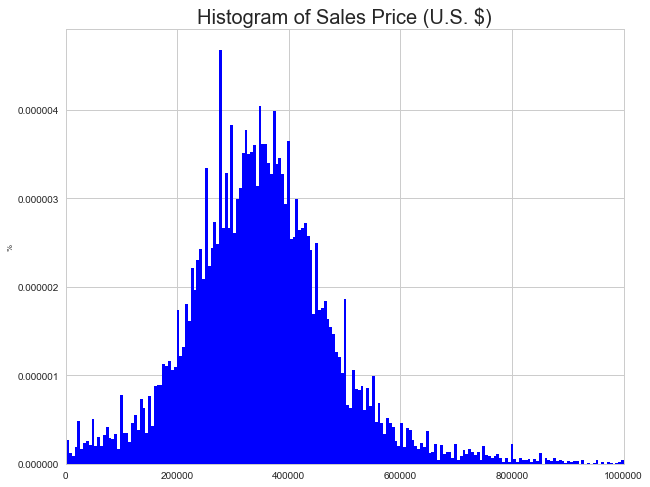

In [11]:
plt.figure(figsize=(10, 8))
plt.hist(sales['price'], bins=1000, density=True, color='blue')
plt.title('Histogram of Sales Price (U.S. $)', fontsize=20)
plt.ylabel('%', fontsize=8)
plt.xlim(0, 1000000)

Text(0,0.5,'U.S. %')

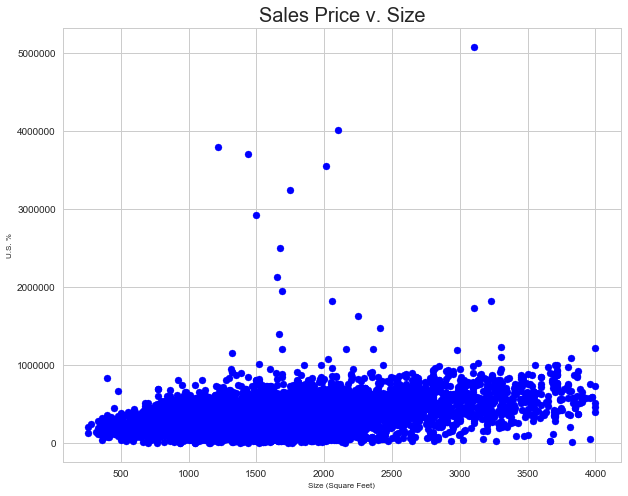

In [12]:
plt.figure(figsize=(10, 8))
plt.scatter(sales['gsf'], sales['price'], c='b')
plt.title('Sales Price v. Size', fontsize=20)
plt.xlabel('Size (Square Feet)', fontsize=8)
plt.ylabel('U.S. %', fontsize=8)

# Accessing Data: Many Tools and Getting Easier

* Using Pandas and Pandas DataReader
* You can read about the development of Pandas, which is Python's equivalent of the R DataFrame.
* Community has grown, spawning a 'spin off' called Pandas DataReader.
* pip install pandas_datareader.
* See: https://pydata.github.io/pandas-datareader/stable/whatsnew.html
* Flexibility to access a lot of public data, including the Federal Reserve Economic Database (FRED) and Enigma IO.

In [13]:
import pandas_datareader.data as web
import datetime
start, end = datetime.datetime(1960, 1, 1), datetime.datetime(2018, 6, 30)
gdp = web.DataReader('GDP', 'fred', start, end)

Text(0,0.5,'Million U.S. $ (Nominal)')

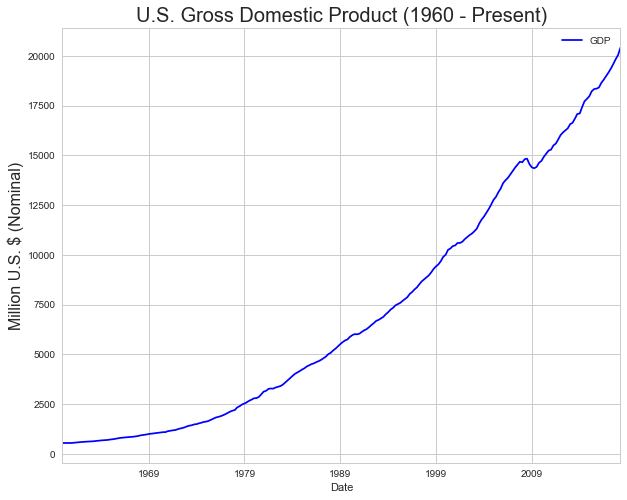

In [14]:
gdp.plot(color='blue', figsize=(10, 8))
plt.title('U.S. Gross Domestic Product (1960 - Present)', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Million U.S. $ (Nominal)', fontsize=16)

In [15]:
from fredapi import Fred
fred = Fred(api_key='30e6ecb242a73869e11cb35f6aa3afc3')
gdp_pc = fred.get_series('A229RX0A048NBEA')

/Users/timothysavage/anaconda/lib/python3.5/site-packages/fredapi/fred.py:143: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  data[self._parse(child.get('date'))] = val


Text(0,0.5,'U.S. $ (2009 Real)')

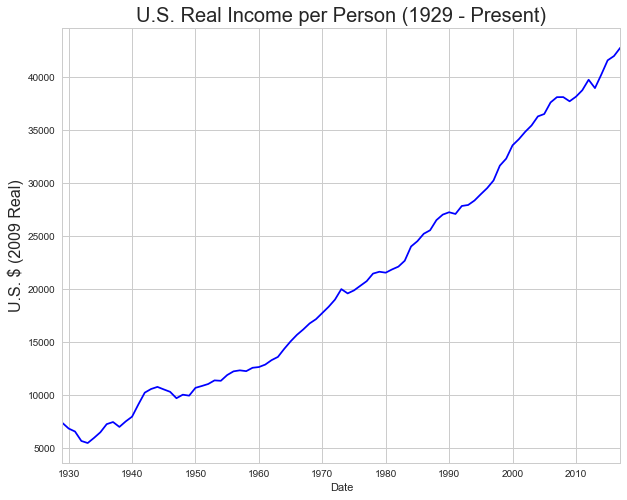

In [16]:
gdp_pc.plot(color='blue', figsize=(10 ,8))
plt.title('U.S. Real Income per Person (1929 - Present)', fontsize=20)
plt.xlabel('Date')
plt.ylabel('U.S. $ (2009 Real)', fontsize=16)

# Regression with Multiple Features and Diagnostics

It is trivial to extend the single-feature linear model to a linear model that simultaneously incorporates multiple features.  The interpretation of the results of a statistical model that uses multiple features is the same the interpretation of the partial derivative from the calculus of many variables: the effect of a small change in a particular feature on a label (or outcome).  

A model with $K$ features, $x_{ik}$ and label $y_i$:

$y_i=\sum_{k=1}^Kx_{ik}\cdot\beta_k+\epsilon_i = x_i^\prime \beta + \epsilon_i$

The $K$ features $x_{ik}$ influence the label $y_i$ through the $K$-vector, $\beta$, which we estimate statistically.  A specific partial derivative interpretation.

${\displaystyle \frac{\partial E(y_i)}{\partial x_{ik}}=\beta_k}$

(For those interested in ancient history: Frisch–Waugh–Lovell theorem.)

Bottom line is simple: Fit the linear model with multiple features.  The basic approach to hypothesis testing remains unchanged. The challenge is the interpretation of the results, which we will discuss in detail.  

### Notes

* We will use a curated dataset from Enigma.IO
* DATA DICTIONARY
    * price: Sales price in dollars
    * unit_size: Size of dwelling in square meters
    * land_size: Size of land on which dwelling sits in square meters
    * age: Age of dwelling in years at sale
    * todt: Indicator (or dummy variable) of whether a dwelling is in Todt Hill, Staten Island
    * sales_year: Year of sale

In [17]:
sales = pd.read_stata('SI Sales.dta')
sales.head()

,price,unit_size,land_size,age,todt,sales_year
0,327500.0,142.699005,232.257507,32.0,0.0,2011.0
1,346314.0,195.096298,239.318130,10.0,0.0,2006.0
2,349830.0,179.488602,201.413712,1.0,0.0,2006.0
3,325000.0,174.750549,227.612350,106.0,0.0,2005.0
4,285000.0,97.083633,271.741272,104.0,0.0,2003.0


In [18]:
sales.describe()

,price,unit_size,land_size,age,todt,sales_year
count,3.168000e+04,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000
mean,4.021063e+05,161.038956,326.063385,35.846844,0.007102,2006.567139
std,2.395515e+05,79.404526,289.825500,31.082470,0.083968,2.766370
min,5.050000e+04,20.067047,24.340586,0.000000,0.000000,2003.000000
25%,2.919750e+05,114.456497,185.806000,9.000000,0.000000,2004.000000
50%,3.710000e+05,145.671906,252.696167,27.000000,0.000000,2006.000000
75%,4.550000e+05,184.969879,380.902313,56.000000,0.000000,2009.000000
max,7.700000e+06,1431.077759,10788.825195,119.000000,1.000000,2013.000000


In [19]:
sales.corr()

,price,unit_size,land_size,age,todt,sales_year
price,1.000000,0.549706,0.505356,-0.064088,0.352151,0.096092
unit_size,0.549706,1.000000,0.446105,-0.201536,0.326307,0.023416
land_size,0.505356,0.446105,1.000000,0.274697,0.346801,0.077402
age,-0.064088,-0.201536,0.274697,1.000000,0.005157,0.125040
todt,0.352151,0.326307,0.346801,0.005157,1.000000,0.012260
sales_year,0.096092,0.023416,0.077402,0.125040,0.012260,1.000000


#### Notes

* Examine the correlation patterns.
* Prices are positively correlated with house size and land size.
* Prices are negatively correlated with age.
* We will talk about 'todt' below.
* Start with simple regression we have already seen.

In [20]:
mod = smf.ols(formula='price ~ unit_size', data = sales).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                 1.372e+04
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        18:03:43   Log-Likelihood:            -4.3166e+05
No. Observations:               31680   AIC:                         8.633e+05
Df Residuals:                   31678   BIC:                         8.633e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.35e+05   2542.335     53.118      0.0

### How to intepret these results?

* For every additional square meter of dwelling size, sales price is 1,658 dollars higher.
* The t-stat is in excess of 2 in absolute value, therefore we reject the null of no or zero effect.
* A 95% confidence interval of this effect is [1630, 1686], which excludes zero.  Therefore, we reject the null of no or zero effect.
* Average unit size is 161 square meters, with a standard deviation of 79 square meters.  
* Therefore, an increase of one standard deviation in dwelling size would increase the sales price by 79 * 1,658 = 130,982 dollars.

## Goodness of Fit: R$^2$

Different statisical computing environments largely produce the same regression ouput, formatted differently.  This output is typically referred to as 'regression diagnosgics.'  Python's statsmodels basically mirrors the regression diagnostics produced by Stata.  We have already reviewed coefficients and their interpretation, as well as the use of standard errors, t values, and confidence intervals for hypothesis testing. 

The R$^2$ 'goodness of fit' metric is a frequently-cited regression diagnostic.  If a linear regression uses a constant (which should be included in practice), the R$^2$ is bounded between 0 and 1.  It measures the share of the variation in $y$ explained by the variation in the features used in a model.  Given this definition, 'bigger is better' is the first place that people go to evaluate the quality of the model, which is unwarranted.  

> "However, it can still be challenging to determine what is a good R$^2$ value, and in general, this will depend on the application.  For instance, in certain problems in physics, we may know that the data truly comes from a linear model with a small residual error.  In this case, we would expect to see an R$^2$ value that is extremely close to 1, and a substantially smaller R$^2$ might indicate serious problems with the experiment in which the data were generated.  On the other hand, in typical application in biology, pyschology, marketing and other domains, the linear model is at best an extremely rough approximation to the data, and residual errors due to other unmeasured factors are often very large.  In this setting, we would expect only a very small proportion of the variance in the response to be explained by the predictor, and an R$^2$ value well below 0.1 might be more realistic."  
Trevor Hastie, Robert Tibshirani, et al.

### My R$^2$ Is One (!)

In [21]:
gdp['lag_gdp']=gdp['GDP'].shift()
gdp = gdp.dropna()
gdp.head()

,GDP,lag_gdp
DATE,,
1960-04-01,541.080,542.648
1960-07-01,545.604,541.080
1960-10-01,540.197,545.604
1961-01-01,545.018,540.197
1961-04-01,555.545,545.018


In [22]:
mod = smf.ols(formula='GDP ~ lag_gdp', data = gdp).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.194e+06
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        18:03:43   Log-Likelihood:                -1287.5
No. Observations:                 233   AIC:                             2579.
Df Residuals:                     231   BIC:                             2586.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.8363      6.244      4.298      0.0

### The example above re-inforces the point above from Professors Hastie and Tibshirani to consider your application (or use case).  In processes that changing slowly, the predictive power of a model (or representation) should be very good, reflected in the R$^2$.

## Other Diagnostics to Assess Model Quality

Adjusted R$^2$: A metric that captures the penalty in the use of a large number of features with little explanatory power.  

AIC (the Akaike Information Criterion): a measure of the relative quality of a statistical model for a given set of data.  It captures the trade-off between the goodness of fit and the complexity of the model.  For example, if I have $N$ $(y,x)$ pairs, I could in principle fit an $N-1$ degree polynomial that passed through all points.  Such an approach, however, should be penalized because of so-called 'overfitting'.

BIC (the Bayes Information Criterion): another measure of relative quality.  Rule of thumb: chose the model with the lowest BIC.

## Extend to two features

* Perhaps we believe that more than one feature can simultaneously affect sales prices.
* We can easily use multivariate regression to account for many features at once.
* When we add an additional feature, namely the land size, we find that it has an independent effect.
* Holding constant unit_size, an increase in land_size of one square meter independently increases the sales price by 268 dollars.
* In addition, note that the effect of unit size on price has fallen from 1,658 to 1,221.
* Moreover, the 95% Confidence Intervals do not overlap.
* What does this indicate?

In [23]:
mod = smf.ols(formula='price ~ unit_size + land_size', data = sales).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     9985.
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        18:03:43   Log-Likelihood:            -4.2961e+05
No. Observations:               31680   AIC:                         8.592e+05
Df Residuals:                   31677   BIC:                         8.593e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.179e+05   2397.598     49.177      0.0

### This is evidence of omitted variable bias (sometimes called the "collinearity problem")
* Failing to include land_size has biased up the measured effect of unit_size because the two features are positively correlated.
* The two features, however, have independent effects on sales prices.
* In this example, we can compare the R-squared measures across the two models because one is nested in the other.  
* We see that the R-squared rises from 0.302 to 0.387, indicating a considerable improvement in the fit of the data.

### More features
* Now let's examine what happens when we account for the age of the dwelling at the date of sale.
* Thoughts about how age might affect sales prices?
* Negative impact: old houses (of equal size) have lower sales prices.
* Note, however, that there is little impact on the effects of the other features when we add age to the model.

In [24]:
mod = smf.ols(formula='price ~ unit_size + land_size + age', data = sales).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     6840.
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        18:03:43   Log-Likelihood:            -4.2945e+05
No. Observations:               31680   AIC:                         8.589e+05
Df Residuals:                   31676   BIC:                         8.589e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.496e+05   2940.848     50.854      0.0

### Indicator Variables: Supervised to Semi-supervised

* Indicator variables capture potential 'discontinuities'.
* CUSP's MOM (Christine) told me that Todt Hill is an upscale area in Staten Island.
* Suppose we want to capture this feature of the data, which we can do using the indicator "todt". 
* 3.574e+05 = 357,400 dollar premium in Todt Hill

In [25]:
mod = smf.ols(formula='price ~ unit_size + land_size + age + todt', data = sales).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     5421.
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        18:03:43   Log-Likelihood:            -4.2910e+05
No. Observations:               31680   AIC:                         8.582e+05
Df Residuals:                   31675   BIC:                         8.582e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.674e+05   2985.210     56.076      0.0

### Scaling of data
* Suppose we wanted to rescale the sales prices because they are measured in dollars (and are large).
* Rescale the label by dividing by 1000.
* This rescaling changes nothing other than how we express the results.  For example, we have more signigicant digits on the 'todt' indicator, 357,431 dollar premium.

In [26]:
sales['priceper1000'] = sales['price']/1000
sales.head()

,price,unit_size,land_size,age,todt,sales_year,priceper1000
0,327500.0,142.699005,232.257507,32.0,0.0,2011.0,327.500
1,346314.0,195.096298,239.318130,10.0,0.0,2006.0,346.314
2,349830.0,179.488602,201.413712,1.0,0.0,2006.0,349.830
3,325000.0,174.750549,227.612350,106.0,0.0,2005.0,325.000
4,285000.0,97.083633,271.741272,104.0,0.0,2003.0,285.000


In [27]:
mod = smf.ols(formula='priceper1000 ~ unit_size + land_size + age + todt', data = sales).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:           priceper1000   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     5421.
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        18:03:43   Log-Likelihood:            -2.1026e+05
No. Observations:               31680   AIC:                         4.205e+05
Df Residuals:                   31675   BIC:                         4.206e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    167.3977      2.985     56.076      0.0

### Introducing Non-Linearities to the Linear Model

* Suppose we want to consider the potential of non-linearities in $y=f(x)$.
* We can use the linear model to do so, but must consider the calculus behind it.
* One conjecture is that age has a diminishing effect on sales prices.
* How to capture this conjecture?

In [28]:
sales['age2'] = sales['age'] ** 2

In [29]:
mod = smf.ols(formula='price ~ unit_size + land_size + age + age2 + todt', data = sales).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     4405.
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        18:03:43   Log-Likelihood:            -4.2899e+05
No. Observations:               31680   AIC:                         8.580e+05
Df Residuals:                   31674   BIC:                         8.581e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.429e+05   3432.491     41.643      0.0

### How to Interpret?

A model with $K$ features, $x_{ik}$ and label $y_i$: $y_i=\sum_{k=1}^Kx_{ik}\cdot\beta_k+\epsilon_i = x_i^\prime \beta + \epsilon_i$

$\frac{\partial{E(y_i})}{\partial{x_{ik}}}=\hat{\beta_k}$

$\frac{\partial{E(\text{sales price}})}{\partial{\text{age}}}=\hat{\beta_\text{age}} + 2\cdot\hat{\beta_\text{age2}}\cdot{\text{age}} = 997 - 2\cdot17\cdot\text{age} = 997 - 34\cdot\text{age}$

The average age of a house in our data is 36 years, so $997 - 34*36 = 997 - 1224 = -227$.  Therefore, when a house hits its average age, its value is declining every year.  

Indeed, we can solve the simple algebra problem, $997 - 34*age = 0$, for age to obtain $\text{age}\approx29$.  For the first 29 years, house prices on average rise for each year, and then begin to decline for subsequent years.

In [30]:
sales['unit_size2'] = sales['unit_size'] ** 2
sales['land_size2'] = sales['land_size'] ** 2

In [31]:
mod = smf.ols(formula='price ~ unit_size + unit_size2 + land_size + land_size2 + age + age2 + todt', data = sales).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     3212.
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        18:03:44   Log-Likelihood:            -4.2886e+05
No. Observations:               31680   AIC:                         8.577e+05
Df Residuals:                   31672   BIC:                         8.578e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.482e+05   4678.551     31.686      0.0

### Let's examine these results.  
* Prices appear to be linear in unit size.
* Prices appear to be quadratic in land_size: a positive but diminishing effect.  At what point does the positive effect disappear.
* Prices appear to be quadatric in age: initially rising and then falling in age as houses reach the sample's average age.

### Feature Engineering: Elasticities

* It may be of use to engineer your features so that results are unit free.
* The interpretation is: for at 1% change in the feature, what is the % change in the label.
* This can be achieved by tranforming the feature and labels using logarithms.

In [32]:
sales['logprice'] = np.log(sales['price'])
sales['logunit'] = np.log(sales['unit_size'])
sales['logland'] = np.log(sales['land_size'])
sales['logage'] = np.log(sales['age']+1)

In [33]:
mod = smf.ols(formula='logprice ~ logunit + logland + logage + todt', data = sales).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:               logprice   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     4540.
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        18:03:44   Log-Likelihood:                -12511.
No. Observations:               31680   AIC:                         2.503e+04
Df Residuals:                   31675   BIC:                         2.507e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.7769      0.029    332.252      0.0

* A 10% change in unit size increases sales price by 3.4%.
* A 10% change in land size increases sales price by 2.6%.
* A 10% change in age decreases sales prices by 0.5%.
* Prices in Todt Hill are about 44% higher holding all else constant.
* Is this model directly comparable to the one above?
* No because we non-linearly transformed both the label and the features.

### Feature Engineeing: Orthonormalization (Mean Zero, Variance One Data)

In [34]:
sales = pd.read_stata('SI Sales.dta')
sales.describe()

,price,unit_size,land_size,age,todt,sales_year
count,3.168000e+04,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000
mean,4.021063e+05,161.038956,326.063385,35.846844,0.007102,2006.567139
std,2.395515e+05,79.404526,289.825500,31.082470,0.083968,2.766370
min,5.050000e+04,20.067047,24.340586,0.000000,0.000000,2003.000000
25%,2.919750e+05,114.456497,185.806000,9.000000,0.000000,2004.000000
50%,3.710000e+05,145.671906,252.696167,27.000000,0.000000,2006.000000
75%,4.550000e+05,184.969879,380.902313,56.000000,0.000000,2009.000000
max,7.700000e+06,1431.077759,10788.825195,119.000000,1.000000,2013.000000


#### Notes

* This can be done variable by variable.
* We could apply this to the entire dataframe, but typically we don't orthonormalize indicatory variables.
* sales = (sales - sales.mean()) / sales.std()

In [35]:
sales['price'] = (sales['price'] - sales['price'].mean()) / sales['price'].std()
sales['unit_size'] = (sales['unit_size'] - sales['unit_size'].mean()) / sales['unit_size'].std()
sales['land_size'] = (sales['land_size'] - sales['land_size'].mean()) / sales['land_size'].std()
sales['age'] = (sales['age'] - sales['age'].mean()) / sales['age'].std()

In [36]:
sales.describe()

,price,unit_size,land_size,age,todt,sales_year
count,3.168000e+04,31680.000000,31680.000000,3.168000e+04,31680.000000,31680.000000
mean,5.060749e-17,0.000001,-0.000018,-9.173627e-09,0.007102,2006.567139
std,1.000000e+00,1.000006,1.000004,1.000010e+00,0.083968,2.766370
min,-1.467769e+00,-1.775364,-1.041050,-1.153282e+00,0.000000,2003.000000
25%,-4.597395e-01,-0.586647,-0.483937,-8.637294e-01,0.000000,2004.000000
50%,-1.298522e-01,-0.193529,-0.253143,-2.846249e-01,0.000000,2006.000000
75%,2.208030e-01,0.301380,0.189214,6.483769e-01,0.000000,2009.000000
max,3.046482e+01,15.994539,36.100211,2.675243e+00,1.000000,2013.000000


In [37]:
mod = smf.ols(formula='price ~ unit_size + land_size + age + todt', data = sales).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     5421.
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        18:03:44   Log-Likelihood:                -36691.
No. Observations:               31680   AIC:                         7.339e+04
Df Residuals:                   31675   BIC:                         7.343e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0106      0.004     -2.436      0.0

* A one standard deviation increase in unit size increases sales price by 0.34.
* A one standard deviation increase in land size increases sales price by 0.33.
* A one standard deviation increase in age decreases sales price by 0.09.
* Prices in Todt Hill are about 50% higher.

## Another Application: The Returns to Education

### Overview: The Early Days

> “Those talents, as they make a part of his fortune, so do they likewise that of the society to which he belongs. The improved dexterity of a workman may be considered in the same light as a machine or instrument of trade which facilitates and abridges labor, and which, though it costs a certain expense, repays that expense with a profit.”  
Adam Smith, The Wealth of Nations

### Human Capital Theory

+ Human capital (as opposed to physical or financial capital) comprises the abilities, knowledge, education, and other attributes that individuals bring to the labor market.
+ In exchange for their labor to produce economic value in the marketplace, individuals receive wages (or earnings).
+ Strong focus on the development of capital through education and workforce experience. 

### Education: Skill or Signal?

+ One idea is that education increases an individual’s skill, allowing her to capture a higher rents in the labor market.  In other words, higher education increases earings.
+ A separate idea is that education is simply a signal to potential employers about one’s unobservable skill and potential dedication.
    - Places of higher education also allow people to tap into networks to aid in employment (such as MBAs).

### Wages

+ Economist Jacob Mincer specified an approach that relates observed wages to schooling and other measures of human capital, such as job market experience. 
+ Relation is typically expressed as the natural log of wages.  Wages are not normally distributed (no negative wages), but rather could be log-normally distributed.
    - $ln(1+r) ≈ r$ for small $r$, so regression estimates can be viewed as rates of return.

In [38]:
print(np.log(1 + 0.01))
print(np.log(1 + 0.05))
print(np.log(1 + 0.10))

0.00995033085317
0.0487901641694
0.0953101798043


### The Returns to Education

* Goal is measure the 'rate of return' to education.
* Increase, if any, in earnings associated with an additional year of education.
* A simple correlation of wages and years of schooling does not necessarily accurately measure this relation.
    * Could do randomized trials, but substantial ethical objections.
* Let’s look at the Griliches (1979) data.
    * Paper is here: https://athens.src.uchicago.edu/jenni/dvmaster/FILES/griliches77f.pdf

In [39]:
griliches = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/Ecdat/Griliches.csv")
griliches = griliches.drop(griliches.columns[0], 1)
griliches = griliches[['lw', 'school', 'iq', 'age', 'expr', 'tenure', 'med']]

### DATA DICTIONARY
* lw: the log of 1980 earnings per hour.
* school: years of schooling.
* iq: Measured IQ.
* age: age at time of measurement.
* expr: total job market experience.
* tenure: length of time on current job.
* med: mother's level of education. 

### Regression Exercise

Using the Griliches data, summarize the data and display a correlation matrix.  Examine how earings vary with schooling, 'intelligence', age, workplace experiemce, tenure on the current job, and mother's education.

In [40]:
griliches.describe()

,lw,school,iq,age,expr,tenure,med
count,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.00000
mean,5.686739,13.405013,103.856201,21.835092,1.735429,1.831135,10.91029
std,0.428949,2.231828,13.618666,2.981756,2.105542,1.673630,2.74112
min,4.605000,9.000000,54.000000,16.000000,0.000000,0.000000,0.00000
25%,5.380000,12.000000,95.250000,20.000000,0.281500,1.000000,9.00000
50%,5.684000,12.000000,104.000000,22.000000,0.960000,1.000000,12.00000
75%,5.991000,16.000000,113.750000,24.000000,2.440000,2.000000,12.00000
max,7.051000,18.000000,145.000000,30.000000,11.444000,10.000000,18.00000


In [41]:
griliches.corr()

,lw,school,iq,age,expr,tenure,med
lw,1.000000,0.502738,0.347069,0.534505,0.084615,0.163767,0.213232
school,0.502738,1.000000,0.513118,0.448150,-0.241779,-0.049568,0.339561
iq,0.347069,0.513118,1.000000,0.177555,-0.166253,0.019392,0.262826
age,0.534505,0.448150,0.177555,1.000000,0.387501,0.339067,0.103081
expr,0.084615,-0.241779,-0.166253,0.387501,1.000000,0.230744,-0.158790
tenure,0.163767,-0.049568,0.019392,0.339067,0.230744,1.000000,-0.047939
med,0.213232,0.339561,0.262826,0.103081,-0.158790,-0.047939,1.000000


Text(0.5,1,'Histogram of Log Wages (U.S. $)')

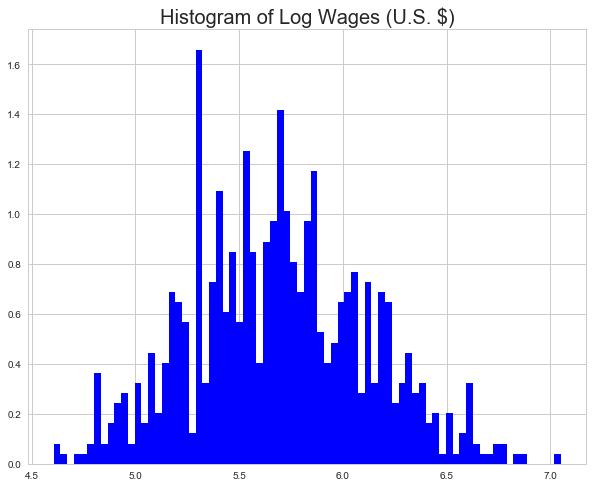

In [42]:
plt.figure(figsize=(10, 8))
plt.hist(griliches['lw'], bins=75, density=True, color='blue')
plt.title('Histogram of Log Wages (U.S. $)', fontsize=20)

Text(0.5,1,'Wages versus Education')

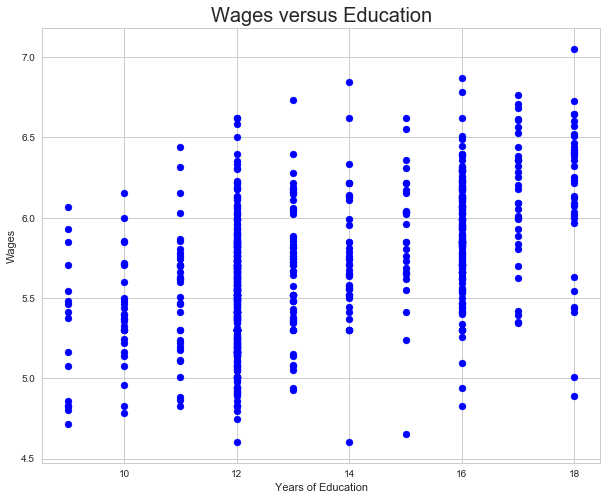

In [43]:
plt.figure(figsize = (10, 8))
plt.scatter(griliches['school'], griliches['lw'], c='b')
plt.xlabel('Years of Education')
plt.ylabel('Wages')
plt.title('Wages versus Education', fontsize = 20)

Text(0.5,1,'Wages versus Age')

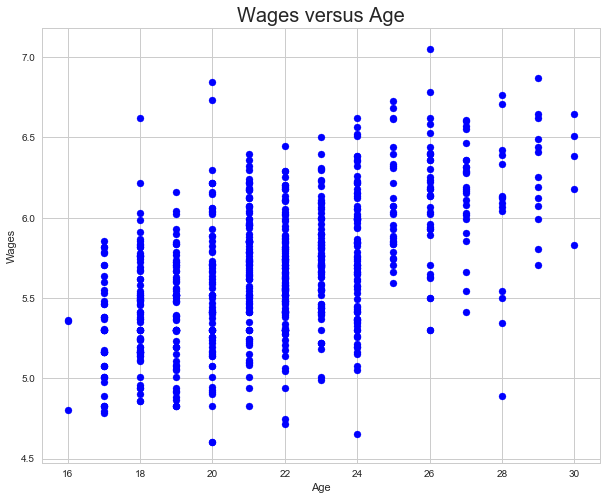

In [44]:
plt.figure(figsize = (10, 8))
plt.scatter(griliches['age'], griliches['lw'], c='b')
plt.xlabel('Age')
plt.ylabel('Wages')
plt.title('Wages versus Age', fontsize=20)

Text(0.5,1,'Wages versus IQ')

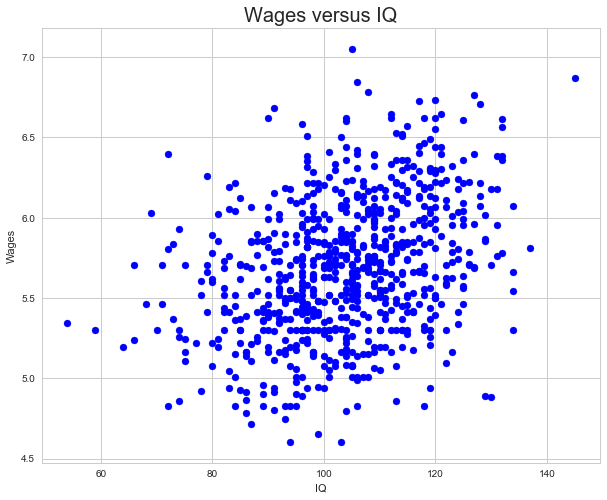

In [45]:
plt.figure(figsize = (10, 8))
plt.scatter(griliches['iq'], griliches['lw'], c='b')
plt.xlabel('IQ')
plt.ylabel('Wages')
plt.title('Wages versus IQ', fontsize=20)

Text(0.5,1,'Wages versus Education of Mother')

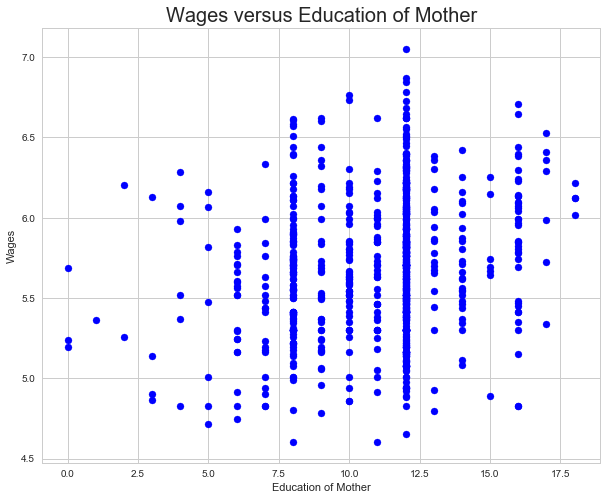

In [46]:
plt.figure(figsize = (10, 8))
plt.scatter(griliches['med'], griliches['lw'], c='b')
plt.xlabel('Education of Mother')
plt.ylabel('Wages')
plt.title('Wages versus Education of Mother', fontsize=20)

In [47]:
mod = smf.ols(formula = 'lw ~ school + iq + age + expr + tenure + med', data = griliches).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                     lw   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     81.33
Date:                Mon, 24 Sep 2018   Prob (F-statistic):           2.51e-78
Time:                        18:03:48   Log-Likelihood:                -243.72
No. Observations:                 758   AIC:                             501.4
Df Residuals:                     751   BIC:                             533.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3016      0.122     26.962      0.0

### What's a Lousy 5% Return?

In [48]:
start, end = datetime.datetime(2008, 6, 30), datetime.datetime(2018, 6, 30)
ten_year = web.DataReader('WGS10YR', 'fred', start, end)

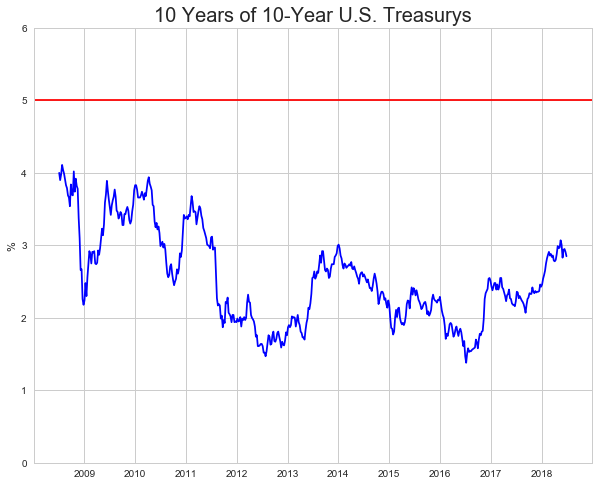

In [49]:
plt.figure(figsize = (10, 8))
plt.plot(ten_year, c='b')
plt.ylabel('%')
plt.ylim(0, 6.0)
plt.title('10 Years of 10-Year U.S. Treasurys', fontsize=20)
plt.axhline(5, color = 'red')

## An Introduction to Principal Components Analysis (PCA)

* Frequently, we wish examine variability with a minimal number of features.  
* PCA is a step in that direction.
* We will use the PCA algorithm from Scikit, which may require the use of arrays rather than dataframes.
    * Even if not, a useful exercise.

### A Matrix

An $(m \times n)$ matrix is an array of numbers ordered into $m$ rows and $n$ columns.

${\displaystyle A = \begin{bmatrix}
a_{11} & a_{12} & ... & a_{1n} \\
a_{21} & a_{22} & ... & a_{2n} \\
... & ... & ... & ... \\
a_{m1} & a_{m2} & ... & a_{mn} 
\end{bmatrix}}$

If $m=1$, then A is row vector with dimension $1 \times n$.  

If $n=1$, then A is a column vector with dimension $m \times 1$.

If $n=m=1$, then A is a scalar.

If $m=n$, then A is said to be a square matrix with dimension $n \times n$.

If all of the off-diagonal elements, $a_{ij} \text{, } i\ne j$, are $0$, then the square matrix is said to be diagonal.

An important square matrix is the identity matrix, $I_n = {\displaystyle \begin{bmatrix}
1 & 0 & ... & 0 \\
0 & 1 & ... & 0 \\
... & ... & ... & ... \\
0 & 0 & ... & 1 \end{bmatrix}}$

### Regression as Projection

One can transpose a matrix, such that if $A$ is $(m \times n)$ then $A ^\prime$ is $(n \times m)$.  Sometimes a $^T$ is used to denote a transpose.  

Under most circumstances, one can invert a square matrix, such that $A \times A^{-1} = I_n$.

The following multiplication is possible for a matrix $X$ of any dimension, $(m \times n)$, $X ^\prime X$.  The $X ^\prime X$ matrix is square of dimension $(n \times n)$, and under most circumstances can be inverted.  

Let $y$ be $(n \times 1)$, $X$ be $(n \times k)$.  The linear system, $y_i=\sum_{k=1}^Kx_{ik}\cdot\beta_k+\epsilon_i = x_i^\prime \beta + \epsilon_i$, where $\beta$ is unknown, can be solved as $\hat{\beta} = (X ^\prime X)^{-1}X ^\prime y$.

The predictor is, thereore, $\hat{y} = X\hat{\beta} = X(X ^\prime X)^{-1}X ^\prime y$, and $X(X ^\prime X)^{-1}X ^\prime$ is said to be the projection matrix of dimension $(n \times n)$.

Through the use of eigenvalues and eigenvectors, which are concepts in linear algebra that describe the projection matrix, PCA seeks to reduce the number of features necessary to explain the variability in $y$.

In [50]:
from sklearn.decomposition import PCA

In [51]:
X = np.array(griliches[['school', 'iq', 'age', 'expr', 'tenure', 'med']])
y = np.array(griliches['lw'])

In [52]:
# How do these arrays appear?

X[0:9], y[0:9]

(array([[  12.   ,   93.   ,   19.   ,    0.462,    0.   ,    8.   ],
        [  16.   ,  119.   ,   23.   ,    0.   ,    2.   ,   14.   ],
        [  14.   ,  108.   ,   20.   ,    0.423,    1.   ,   14.   ],
        [  12.   ,   96.   ,   18.   ,    0.333,    1.   ,   12.   ],
        [   9.   ,   74.   ,   26.   ,    9.013,    3.   ,    6.   ],
        [   9.   ,   91.   ,   16.   ,    0.333,    1.   ,    8.   ],
        [  18.   ,  114.   ,   30.   ,    1.205,    6.   ,    8.   ],
        [  15.   ,  111.   ,   23.   ,    1.25 ,    1.   ,   14.   ],
        [  12.   ,   95.   ,   22.   ,    2.048,    2.   ,   12.   ]]),
 array([ 5.9  ,  5.438,  5.71 ,  5.481,  5.927,  4.804,  6.512,  5.808,
         5.737]))

In [53]:
pca = PCA(n_components=6)
pca.fit(X, y)
print(pca.explained_variance_ratio_)

[ 0.87718694  0.05034181  0.03562309  0.01935177  0.01134569  0.0061507 ]


### One feature explains a large share of the variability in earnings according to PCA for the features included in the PCA.

* Which one?
* Stayed tuned.